# Exercise 1.2
## Classification of MNIST digits with a convolutional neural network

In this exercise we will classify MNIST digits again, but this time we will use a convolutional neural network (CNN).

First we import the modules we need

In [21]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

We check that this script has a GPU available

In [22]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We import the MNIST dataset, which is built into pytorch

In [30]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=30),
    ])

batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

You should implement a network to classify MNIST digits. 
The network should consist of two parts, a part with convolutions and one with fully connected layers.
The convolutional part we will call `convolutional`, and it should contain the follwing:
* two convolutional layers with 8 features
* a $2\times2$ max pooling layer
* two convolutional layers with 16 features

The convolutions should be $3\times 3$, and should not change the size of the output. What does this mean that the stride and padding should be?

For example check the documentation of the `nn` module https://pytorch.org/docs/stable/nn.html

**Remember**: There's a specific type of layer that you should always have after a convolution or a fully connected layer. What is this type of layer called?

In [61]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(1, 8, 3, padding=1),
                nn.Dropout(0.2),
                nn.ReLU(),
                nn.Conv2d(8, 8, 3, padding=1),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.MaxPool2d((2,2)),
                nn.Conv2d(8, 16, 3, padding=1),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Conv2d(16, 16, 3, padding=1),
                nn.Dropout(0.5),
                nn.ReLU())

        self.fully_connected = nn.Sequential(
                nn.Linear(14*14*16, 500),
                nn.ReLU(),
                nn.Linear(500, 10),
                nn.Softmax(dim=1))
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

We instantiate a copy of our network, transfer it to the GPU if it's available.
We also check if the dimensions of our network match.

In [62]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit

Shape of the output from the convolutional part torch.Size([64, 16, 14, 14])


We train this network for five epochs

In [63]:
num_epochs = 5

train_loss_epoch = []
test_loss_epoch = []
train_acc_array = []
test_acc_array = []
for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    training_sum_loss_pr_epoch = 0
    test_sum_loss_pr_epcoch = 0
    model.train()
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        training_sum_loss_pr_epoch += loss.sum().cpu().item() 
        
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    train_loss_epoch.append(training_sum_loss_pr_epoch)
    model.eval()
    #Comput the test accuracy
    test_correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1)
        test_correct += (target==predicted).sum().item()
        test_loss = F.nll_loss(torch.log(output), target)
        test_sum_loss_pr_epcoch += test_loss.sum().cpu().item()
    test_loss_epoch.append(test_sum_loss_pr_epcoch)
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    train_acc_array.append(train_acc)
    test_acc_array.append(test_acc)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))


Accuracy train: 67.9%	 test: 93.4%



Accuracy train: 93.2%	 test: 97.7%



Accuracy train: 94.9%	 test: 97.8%



Accuracy train: 95.7%	 test: 98.6%



Accuracy train: 96.3%	 test: 98.7%



Hopefully you now have a model that's able to achieve decent performance on MNIST.
It should have around 97.5% accuracy on the test set after the first epoch.

* Why is the accuracy on the training set higher than on the test set? (recall from machine learning)

The model is trained on the training set => therefore it is higher

* Why does it have higher accuracy on the test set than the training set after the first epoch?



   hint: it's related to how the train accuracy is computed

### Data augmentation
 * Add random rotations to the MNIST digits during training (you have to go back and modify the dataloader)
 
  hint: you can use `transforms.RandomRotation` 
  
  hint: you can combine multiple transforms into one with `transforms.Compose`

How does this affect your training and testing loss?

 * Try plotting some of the augmented images, to visually confirm what your augmentation is doing.

 * Try adding another type of data augmentation.

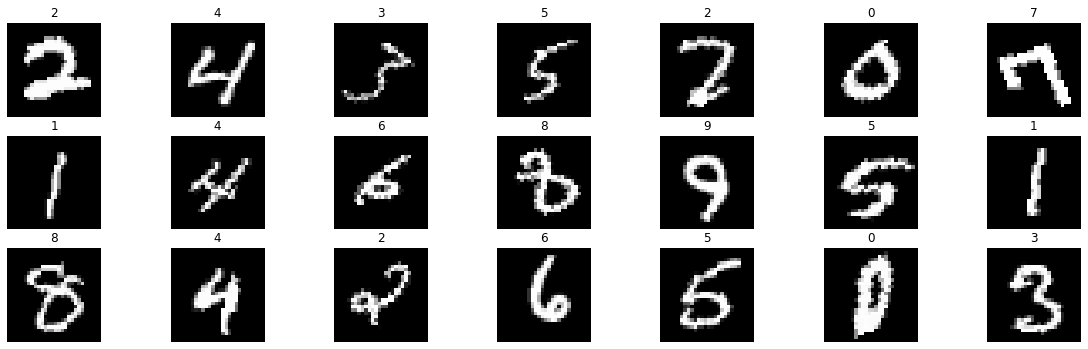

In [64]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

Text(0.5, 1.0, 'Loss')

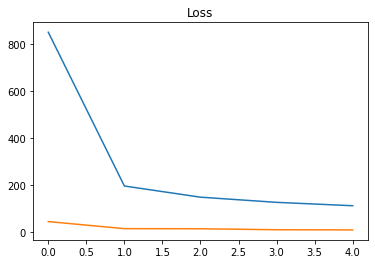

In [65]:
plt.plot(np.arange(num_epochs), train_loss_epoch)
plt.plot(np.arange(num_epochs), test_loss_epoch)
plt.title("Loss")

### Explore the model
What has the model learned? You can access all the weights in the model with `model.parameters()`. Here we just print the shape.
 - Try showing images of the filters in the first layer. 
 - Can you from the dimensions of the weights alone identify which layer it is in our model?

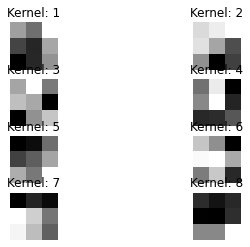

In [66]:
parameters = [w for w in model.parameters()]
layer_1 = parameters[0]

for i, filter in enumerate(layer_1):
  plt.subplot(4,2,i+1)
  plt.imshow(filter.cpu().detach().numpy()[0], 'gray')
  plt.title(f'Kernel: {i+1}')
  plt.axis('off')

### Dropout
 * Try adding dropout to your model.
 
You can add it between the convolutional layers and or in the fully connected part.

Remember to call `net.train()` and `net.eval()` to change the model from test to training state, so it knows when you want it to apply dropout.